In [1]:
import pandas as pd
import seaborn as sb
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

df = pd.read_csv("phiusiil+phishing+url+dataset.zip", compression="zip")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235795 entries, 0 to 235794
Data columns (total 56 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   FILENAME                    235795 non-null  object 
 1   URL                         235795 non-null  object 
 2   URLLength                   235795 non-null  int64  
 3   Domain                      235795 non-null  object 
 4   DomainLength                235795 non-null  int64  
 5   IsDomainIP                  235795 non-null  int64  
 6   TLD                         235795 non-null  object 
 7   URLSimilarityIndex          235795 non-null  float64
 8   CharContinuationRate        235795 non-null  float64
 9   TLDLegitimateProb           235795 non-null  float64
 10  URLCharProb                 235795 non-null  float64
 11  TLDLength                   235795 non-null  int64  
 12  NoOfSubDomain               235795 non-null  int64  
 13  HasObfuscation

,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,521848.txt,https://www.southbankmosaics.com,31,www.southbankmosaics.com,24,0,com,100.0,1.000000,0.522907,...,0,0,1,34,20,28,119,0,124,1
1,31372.txt,https://www.uni-mainz.de,23,www.uni-mainz.de,16,0,de,100.0,0.666667,0.032650,...,0,0,1,50,9,8,39,0,217,1
2,597387.txt,https://www.voicefmradio.co.uk,29,www.voicefmradio.co.uk,22,0,uk,100.0,0.866667,0.028555,...,0,0,1,10,2,7,42,2,5,1
3,554095.txt,https://www.sfnmjournal.com,26,www.sfnmjournal.com,19,0,com,100.0,1.000000,0.522907,...,1,1,1,3,27,15,22,1,31,1
4,151578.txt,https://www.rewildingargentina.org,33,www.rewildingargentina.org,26,0,org,100.0,1.000000,0.079963,...,1,0,1,244,15,34,72,1,85,1


In [2]:
'''
FILENAME dropped since its not relevant to the data and url is removed since 
useful information from url is already extracted into feature columns
'''
df = df.drop(['FILENAME', 'URL', 'Domain', 'Title'], axis=1)

#TLD can be dropped or kept depending on how useful it is for the models, should do testing including and removing it
#df = df.drop(['TLD'], axis=1)
label_encoder = LabelEncoder()
df['TLD'] = label_encoder.fit_transform(df['TLD'])

In [3]:
df.isnull()
df.duplicated()
df.dropna()
df.drop_duplicates()

,URLLength,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,31,24,0,231,100.000000,1.000000,0.522907,0.061933,3,1,...,0,0,1,34,20,28,119,0,124,1
1,23,16,0,254,100.000000,0.666667,0.032650,0.050207,2,1,...,0,0,1,50,9,8,39,0,217,1
2,29,22,0,647,100.000000,0.866667,0.028555,0.064129,2,2,...,0,0,1,10,2,7,42,2,5,1
3,26,19,0,231,100.000000,1.000000,0.522907,0.057606,3,1,...,1,1,1,3,27,15,22,1,31,1
4,33,26,0,503,100.000000,1.000000,0.079963,0.059441,3,1,...,1,0,1,244,15,34,72,1,85,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235790,29,22,0,231,100.000000,1.000000,0.522907,0.058739,3,1,...,1,0,1,51,7,21,187,2,191,1
235791,28,21,0,647,100.000000,0.785714,0.028555,0.053834,2,2,...,1,0,0,50,1,7,88,0,31,1
235792,30,23,0,157,100.000000,1.000000,0.003319,0.063093,2,1,...,0,0,1,27,10,30,58,2,67,1
235793,55,47,0,258,28.157537,0.465116,0.000961,0.050211,3,2,...,0,0,0,0,0,3,0,0,0,0


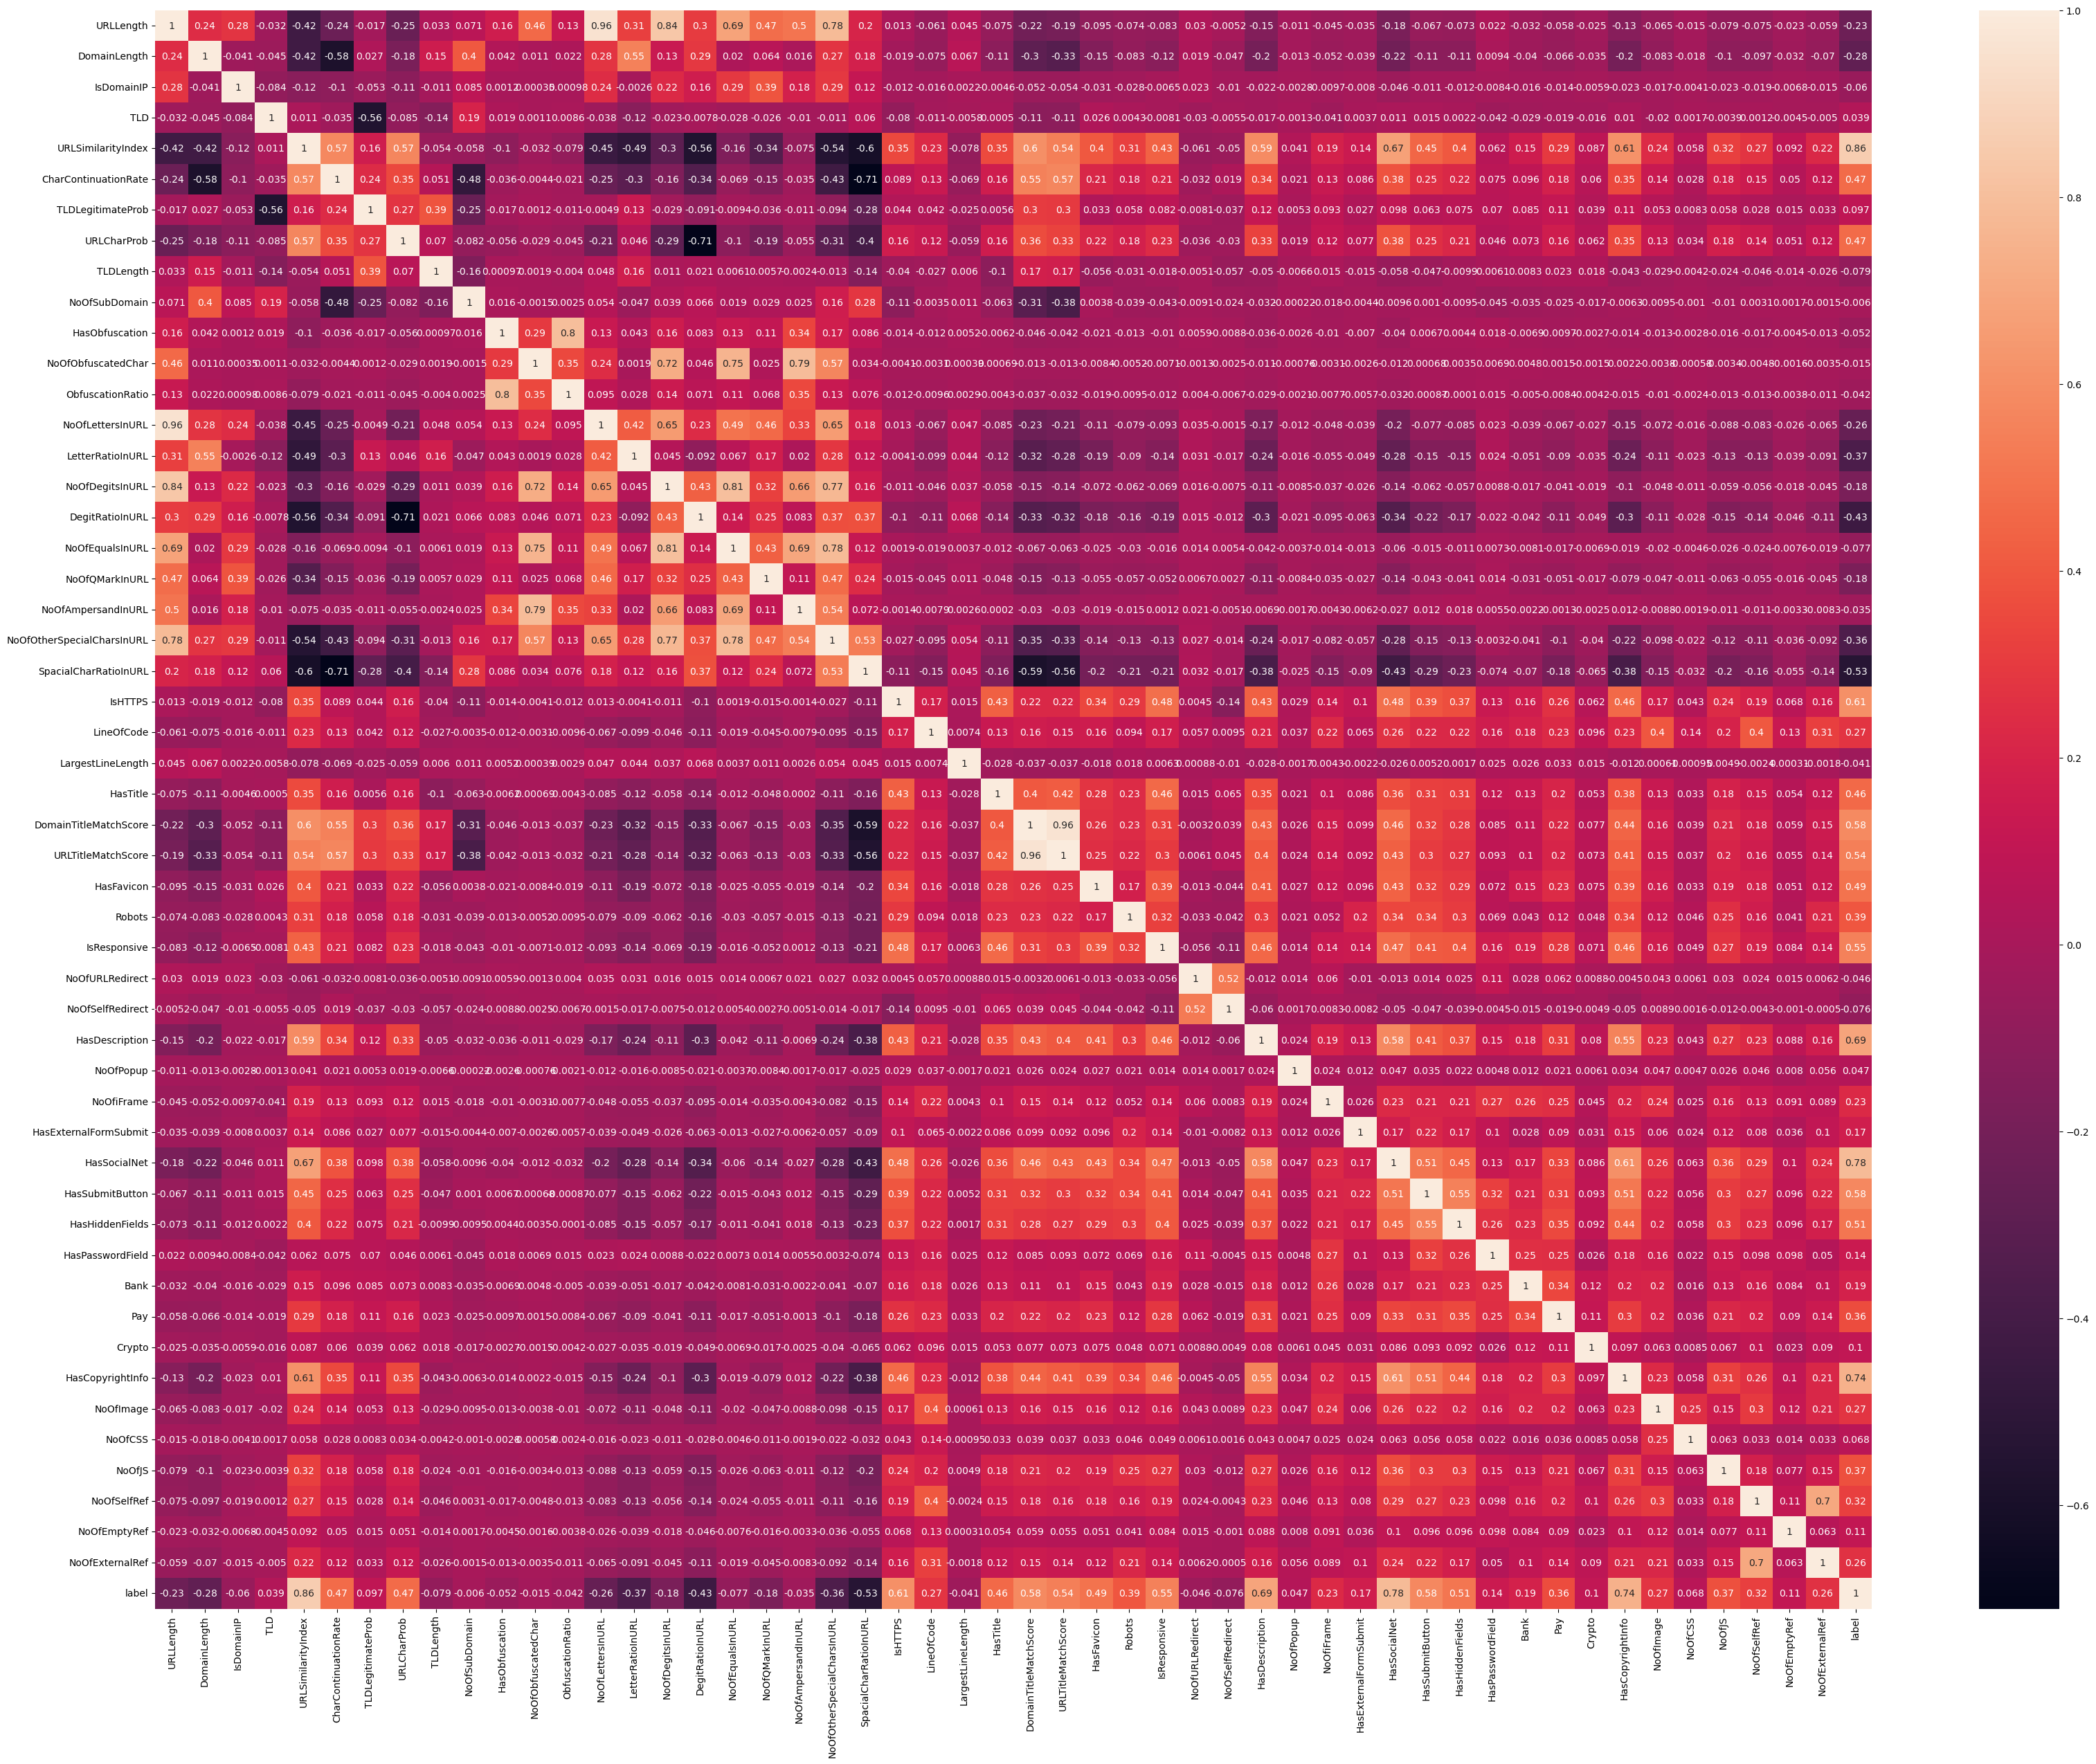

In [4]:
corr = df.corr()
plt.figure(figsize=(40, 30))
sb.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True)
plt.show()

In [5]:
#Dropping highly corrrelated features
# prof said only to drop for logistic regression
#df = df.drop(['URLTitleMatchScore', 'URLLength', 'NoOfAmpersandInURL', 'NoOfLettersInURL'], axis=1) 

In [6]:
features_cleaned = df.copy()
for column in features_cleaned.columns:
    if df[column].nunique() <= 2 or column == 'label':
        continue

    #These features are the only one with reasonable data spreads
    if (column == 'DomainLength' or column == 'URLCharProb' or column == 'LetterRatioInURL' or column == 'SpacialCharRatioInURL'):
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        #df[column].hist(bins=50)
        #plt.show()

        #Identifing outliers (points outside the bounds)
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        
        #Remove the outliers from the DataFrame
        features_cleaned = features_cleaned[(features_cleaned[column] >= lower_bound) & (features_cleaned[column] <= upper_bound)]


In [7]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier
import numpy as np

smaller_sample = features_cleaned.sample(frac=0.1, random_state=42)
final_features = smaller_sample.drop(['label'], axis=1)
standard_scale = StandardScaler()
standard_scale.fit(final_features)
final_features = standard_scale.transform(final_features)

#Checking data imbalance
target = smaller_sample['label']
print(target.value_counts())

original_feature_names = smaller_sample.drop(['label'], axis=1).columns

# need to be in df to prevent error
if isinstance(final_features, np.ndarray):
    final_features = pd.DataFrame(final_features, columns=original_feature_names)

# took too long for all data poitns so took a sample
sample_size = 1000  
final_features = final_features.reset_index(drop=True)
target = target.reset_index(drop=True)
final_features_sample = final_features.sample(n=sample_size, random_state=42)
target_sample = target.iloc[final_features_sample.index]  

# random forest for forward selection
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
sfs_forward = SequentialFeatureSelector(
    rf_model,
    direction="forward",
    scoring="average_precision",
    cv=5,
    n_features_to_select="auto",
    n_jobs=-1
)
sfs_forward.fit(final_features_sample, target_sample)

selected_features = final_features.columns[sfs_forward.get_support()]
print("Selected Features after Forward Selection:", selected_features)
final_features = final_features[selected_features] 


label
1    13399
0     7877
Name: count, dtype: int64
Selected Features after Forward Selection: Index(['URLLength', 'DomainLength', 'IsDomainIP', 'TLD', 'URLSimilarityIndex',
       'CharContinuationRate', 'TLDLegitimateProb', 'URLCharProb', 'TLDLength',
       'NoOfSubDomain', 'HasObfuscation', 'NoOfObfuscatedChar',
       'ObfuscationRatio', 'NoOfLettersInURL', 'LetterRatioInURL',
       'NoOfDegitsInURL', 'DegitRatioInURL', 'NoOfEqualsInURL',
       'NoOfQMarkInURL', 'NoOfAmpersandInURL', 'NoOfOtherSpecialCharsInURL',
       'SpacialCharRatioInURL', 'IsHTTPS', 'LineOfCode', 'LargestLineLength'],
      dtype='object')


In [24]:
smt = SMOTE(random_state=42)
features_res, target_res = smt.fit_resample(final_features, target)
#making sure the class imbalance was resovled
class_imbalance = target_res.value_counts()
print(class_imbalance)

train_features, test_features, train_target, test_target = train_test_split(features_res, target_res, train_size=.8)

label
1    13399
0    13399
Name: count, dtype: int64


In [26]:
selected_features.count()

(25,)


In [50]:
corr_features = find_correlated_features(features_res, threshold=0.5)
print("Highly correlated features (> 0.5) to be removed:", corr_features)
train_features_filtered = train_features.drop(columns=corr_features, errors='ignore')
test_features_filtered = test_features.drop(columns=corr_features, errors='ignore')
logistic_model_filtered = LogisticRegression(random_state=42, max_iter=1000, C=0.1, penalty='l2')
logistic_model_filtered.fit(train_features_filtered, train_target)

logistic_predictions_filtered = logistic_model_filtered.predict(test_features_filtered)
print("Logistic Regression Accuracy:", accuracy_score(test_target, logistic_predictions_filtered))
print("Logistic Regression Classification Report:\n", classification_report(test_target, logistic_predictions_filtered))


Highly correlated features (> 0.5) to be removed: ['DegitRatioInURL', 'NoOfOtherSpecialCharsInURL', 'LetterRatioInURL', 'NoOfEqualsInURL', 'URLSimilarityIndex', 'NoOfAmpersandInURL', 'NoOfDegitsInURL', 'NoOfQMarkInURL', 'NoOfLettersInURL', 'NoOfObfuscatedChar', 'TLDLegitimateProb', 'IsDomainIP', 'ObfuscationRatio', 'URLCharProb', 'SpacialCharRatioInURL']
Logistic Regression Accuracy: 0.9264567669172933
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.83      0.89      1545
           1       0.91      0.98      0.94      2711

    accuracy                           0.93      4256
   macro avg       0.94      0.90      0.92      4256
weighted avg       0.93      0.93      0.93      4256

